# Lab 10.Eng2 
## Text Generation through Bidirectional LSTM model

<table class="tfo-notebook-buttons" align="left">
   <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/text/blob/master/docs/tutorials/text_classification_rnn.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
</table>

## 1) Bidirectional LSTMs

Bidirectional LSTMs are an extension of traditional LSTMs that can improve model performance on sequence classification problems. 

They train the model forward and backward on the same input (so for 1 layer LSTM we get 2 hidden and cell states)
- First from left to right on the input sequence and the second in reversed order of the input sequence. 

### Now let’s see how to implement this model in text generation.

Import the following libraries:

In [1]:
import numpy as np
import tensorflow as tf

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, GRU, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras.utils import to_categorical, plot_model

## 2) Text pre-processing

- In this, the whole text is cleaned and converted to lower case and the whole corpus of sentences are joined. 
- Words are then tokenized

In [2]:
tokenizer = Tokenizer()
data = open('./tiny-shakespeare.txt').read()

In [3]:
len(data)

1115394

In [4]:
data=data[:10000]

In [5]:
corpus = data.lower().split("\n")
tokenizer.fit_on_texts(corpus)
print(tokenizer.word_index)

{'the': 1, 'you': 2, 'and': 3, 'to': 4, 'citizen': 5, 'first': 6, 'that': 7, 'they': 8, 'of': 9, 'it': 10, 'what': 11, 'i': 12, 'for': 13, 'menenius': 14, 'your': 15, 'a': 16, 'with': 17, 'in': 18, 'all': 19, 'are': 20, 'is': 21, 'their': 22, 'not': 23, 'he': 24, 'we': 25, 'but': 26, 'as': 27, 'this': 28, 'us': 29, 'have': 30, 'our': 31, 'me': 32, 'good': 33, 'would': 34, 'well': 35, 'make': 36, 'belly': 37, 'marcius': 38, 'him': 39, 'be': 40, 'one': 41, 'them': 42, 'his': 43, 'say': 44, 'which': 45, "o'": 46, 'who': 47, 'my': 48, 'speak': 49, 'at': 50, 'if': 51, 'did': 52, 'was': 53, 'must': 54, 'do': 55, 'will': 56, 'no': 57, 'second': 58, 'against': 59, 'like': 60, 'know': 61, 'more': 62, 'these': 63, 'other': 64, 'where': 65, 'sir': 66, 'most': 67, 'answer': 68, 'from': 69, 'hear': 70, 'let': 71, 'done': 72, 'poor': 73, 'on': 74, 'an': 75, 'gods': 76, 'even': 77, 'city': 78, 'strong': 79, 'shall': 80, 'friends': 81, 'yourselves': 82, 'tell': 83, 'yet': 84, 'body': 85, 'then': 86, '

In [6]:
print(corpus[:15])

['first citizen:', 'before we proceed any further, hear me speak.', '', 'all:', 'speak, speak.', '', 'first citizen:', 'you are all resolved rather to die than to famish?', '', 'all:', 'resolved. resolved.', '', 'first citizen:', 'first, you know caius marcius is chief enemy to the people.', '']


In [7]:
total_words = len(tokenizer.word_index) + 1
print('total_words=',total_words)

total_words= 672


## 3) Creating Sequences

For each word, an n-gram sequence is made and input sequences are updated. It happens in the iteration for the next word and so on.

- For example, in the sentence below first 'He’ was extracted out then, ‘He was ’ was extracted, and then ‘He was walking ’ was extracted, and so on.

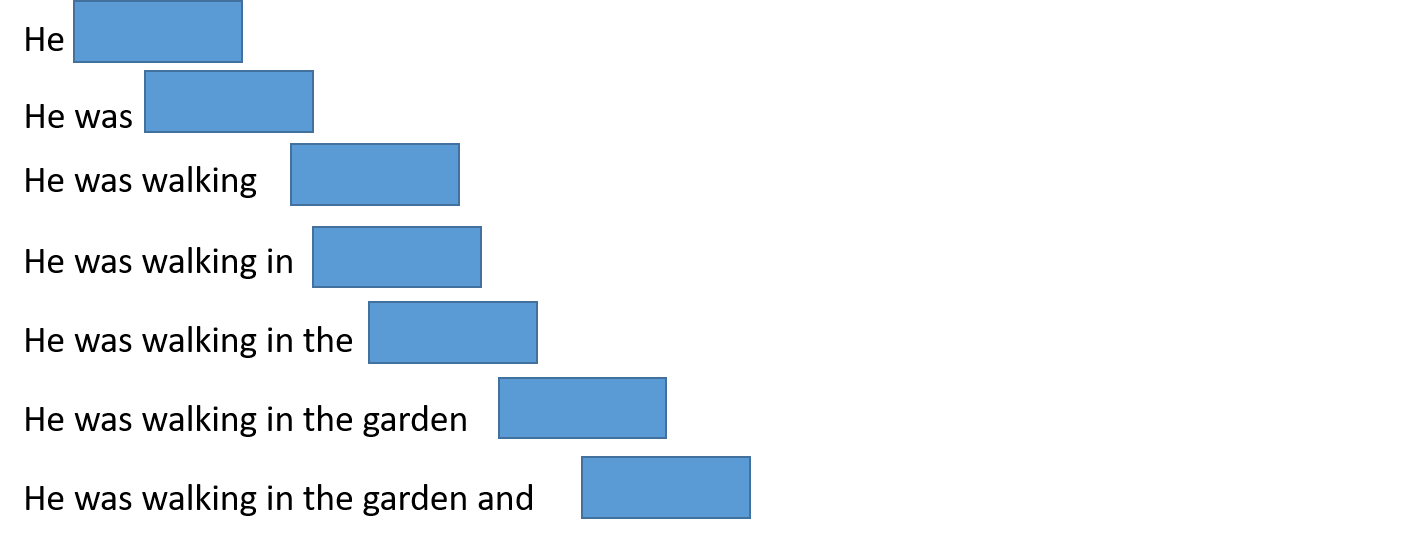

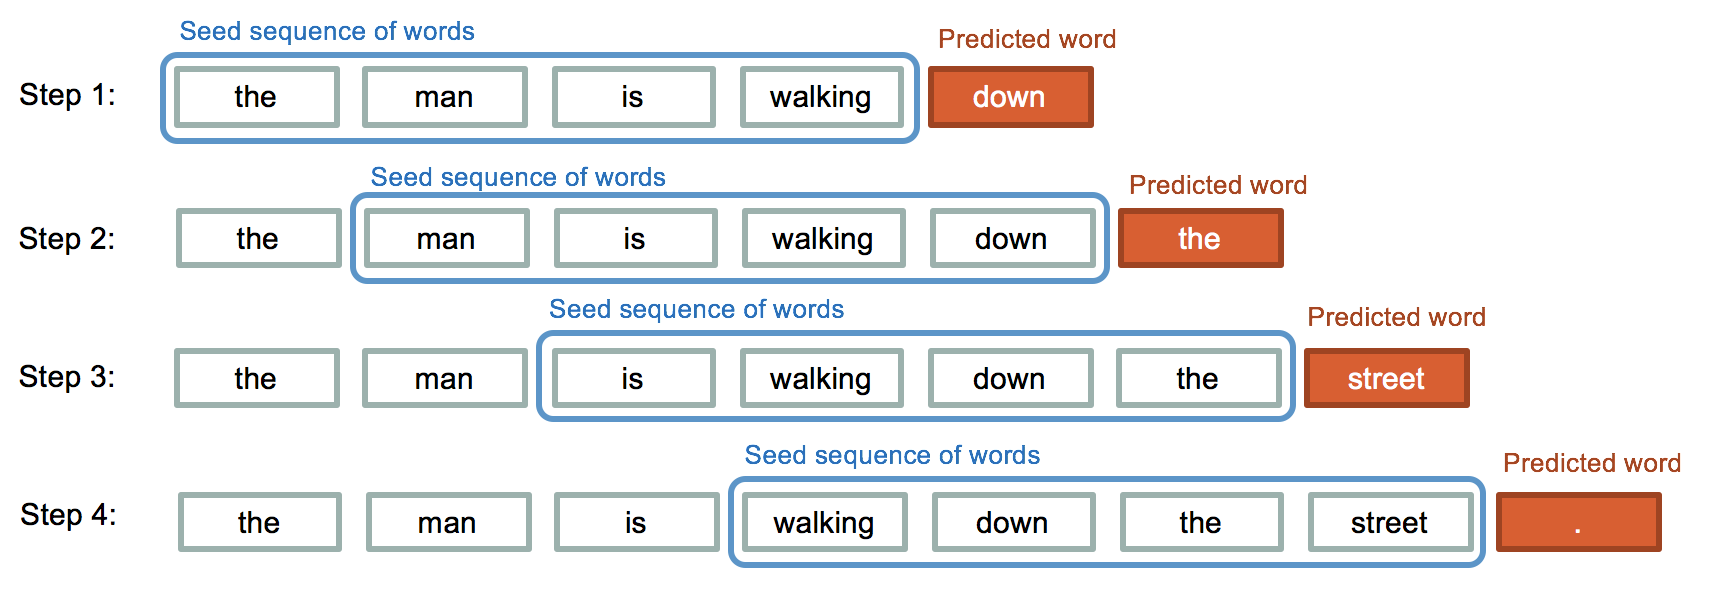

In [8]:
# create input sequences using list of tokens
input_sequences = []
for line in corpus:
    token_list = tokenizer.texts_to_sequences([line])[0]
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i+1]
        input_sequences.append(n_gram_sequence)        

### Padding sequences

- The maximum length of the sentence is extracted and then the rest of the sentences are pre-padded as per the longest sentence.

In [9]:
# pad sequences 
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, 
                                         maxlen=max_sequence_len, 
                                         padding='pre'))

In [10]:
print('max_len', max_sequence_len)
print('total-words',total_words)

max_len 12
total-words 672


### Label
Extract the last word of sequence and convert it to categorical from numerical.

In [11]:
# create predictors and label
predictors, label = input_sequences[:,:-1],input_sequences[:,-1]

label = to_categorical(label, num_classes=total_words)

## 4) Bidirectional LSTM Model
- Let’s make a sequential model now with the first layer as the word embedding layer.
- __'return_sequence'__ is marked as __True__ so that the word generation keeps in consideration, previous and even the words coming ahead in the sequence.

- The output layer has softmax so as to get the probability of the word to be predicted next.

In [12]:
model = Sequential()
model.add(Embedding(total_words, 100, input_length=max_sequence_len-1))
model.add(Bidirectional(LSTM(150, return_sequences = True)))
model.add(LSTM(100))
model.add(Dense(total_words/2, activation='relu' ))
model.add(Dense(total_words, activation='softmax'))

In [32]:
print(model.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 11, 100)           67200     
                                                                 
 bidirectional_1 (Bidirectio  (None, 11, 300)          226800    
 nal)                                                            
                                                                 
 gru_3 (GRU)                 (None, 100)               120600    
                                                                 
 dense_4 (Dense)             (None, 336)               33936     
                                                                 
 dense_5 (Dense)             (None, 672)               226464    
                                                                 
Total params: 675,000
Trainable params: 675,000
Non-trainable params: 0
________________________________________________

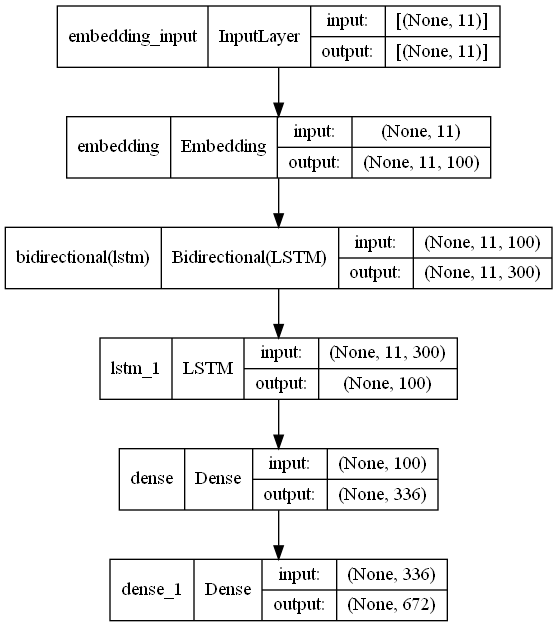

In [15]:
plot_model(model, './fig_lab10_eng2.png', show_shapes=True)

In [16]:
model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

In [17]:
import time
start = time.perf_counter()

The Elapse time for a single CPU is for 100 epochs:: 
 Elapsed 230.794 seconds.

In [18]:
import time
start = time.perf_counter()
history = model.fit(predictors, label, epochs=100, verbose=1)
elapsed = time.perf_counter() - start
print('============================\n Elapsed %.3f seconds.' % elapsed)

Epoch 1/100
47/47 [==============================] - 7s 44ms/step - loss: 6.2330 - accuracy: 0.0512
Epoch 2/100
47/47 [==============================] - 2s 44ms/step - loss: 5.8633 - accuracy: 0.0585
Epoch 3/100
47/47 [==============================] - 2s 47ms/step - loss: 5.7500 - accuracy: 0.0585
Epoch 4/100
47/47 [==============================] - 2s 46ms/step - loss: 5.5735 - accuracy: 0.0725
Epoch 5/100
47/47 [==============================] - 2s 47ms/step - loss: 5.4031 - accuracy: 0.0778
Epoch 6/100
47/47 [==============================] - 2s 47ms/step - loss: 5.2759 - accuracy: 0.0818
Epoch 7/100
47/47 [==============================] - 2s 47ms/step - loss: 5.1476 - accuracy: 0.0824
Epoch 8/100
47/47 [==============================] - 2s 47ms/step - loss: 5.0442 - accuracy: 0.0811
Epoch 9/100
47/47 [==============================] - 2s 47ms/step - loss: 4.9610 - accuracy: 0.0851
Epoch 10/100
47/47 [==============================] - 2s 47ms/step - loss: 4.8580 - accuracy: 0.0951

47/47 [==============================] - 2s 47ms/step - loss: 0.3097 - accuracy: 0.9043
Epoch 83/100
47/47 [==============================] - 2s 48ms/step - loss: 0.2712 - accuracy: 0.9089
Epoch 84/100
47/47 [==============================] - 2s 47ms/step - loss: 0.2516 - accuracy: 0.9116
Epoch 85/100
47/47 [==============================] - 2s 48ms/step - loss: 0.2416 - accuracy: 0.9136
Epoch 86/100
47/47 [==============================] - 2s 48ms/step - loss: 0.2370 - accuracy: 0.9189
Epoch 87/100
47/47 [==============================] - 2s 49ms/step - loss: 0.2322 - accuracy: 0.9195
Epoch 88/100
47/47 [==============================] - 2s 48ms/step - loss: 0.2337 - accuracy: 0.9149
Epoch 89/100
47/47 [==============================] - 2s 49ms/step - loss: 0.2333 - accuracy: 0.9162
Epoch 90/100
47/47 [==============================] - 2s 48ms/step - loss: 0.2244 - accuracy: 0.9169
Epoch 91/100
47/47 [==============================] - 2s 48ms/step - loss: 0.2267 - accuracy: 0.9176
Epo

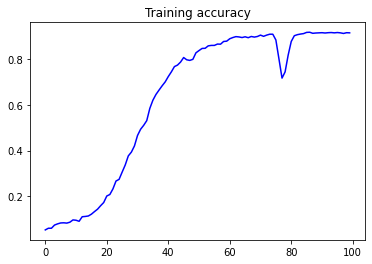

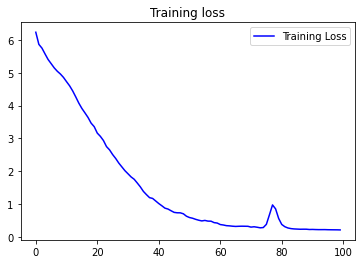

In [19]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
loss = history.history['loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.title('Training accuracy')
plt.figure()
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.title('Training loss')
plt.legend()
plt.show()

## 5) Test for the next generation. 
- 100 next words are generated this way.

In [20]:
seed_text = "First Servingman: A strange one as ever I looked on: I cannot get him!"
next_words = 100

- The seed will be taken at first and tokenized and padded on the token list. 
- Model is then used to predict with the token list as input.
- Then most probable word is added to seed text and this happens for the next 100 words.

In [21]:
for _ in range(next_words):
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
    p_x = model.predict(token_list, verbose=0)
    predicted=np.argmax(p_x,axis=1)
    
    output_word = ""
    for word, index in tokenizer.word_index.items():
        if index == predicted:
            output_word = word
            break
    seed_text += " " + output_word
print(seed_text)

First Servingman: A strange one as ever I looked on: I cannot get him! in pray you account remember you gods you you barren of all the rest were so mark me say he fathers fathers fathers fathers fathers fathers did venture pray you say there's which you to't own belly of man man which he remember remember please please please can which our own price please ye caps please ye price ye caps please ye caps please please ye trust ye 't please please ye 't please please ye 't please please ye 't please please ye 't please please ye 't please please ye 't please please ye 't please please ye


## 6) HW : Optimized Model Architecture
- The output is not perfect as for training we took only a few lines of text. 
- Hence we can very well fine-tune it.

- For each character the model looks up the embedding, runs the GRU one timestep with the embedding as input, and applies the dense layer to generate logits predicting the log-likelihood of the next character:

- To generate more convincing text, you could try using more GRU layers and more neurons per layer, train for longer, and add some regularization (for example, you could set recurrent_dropout=0.3 in the GRU layers).

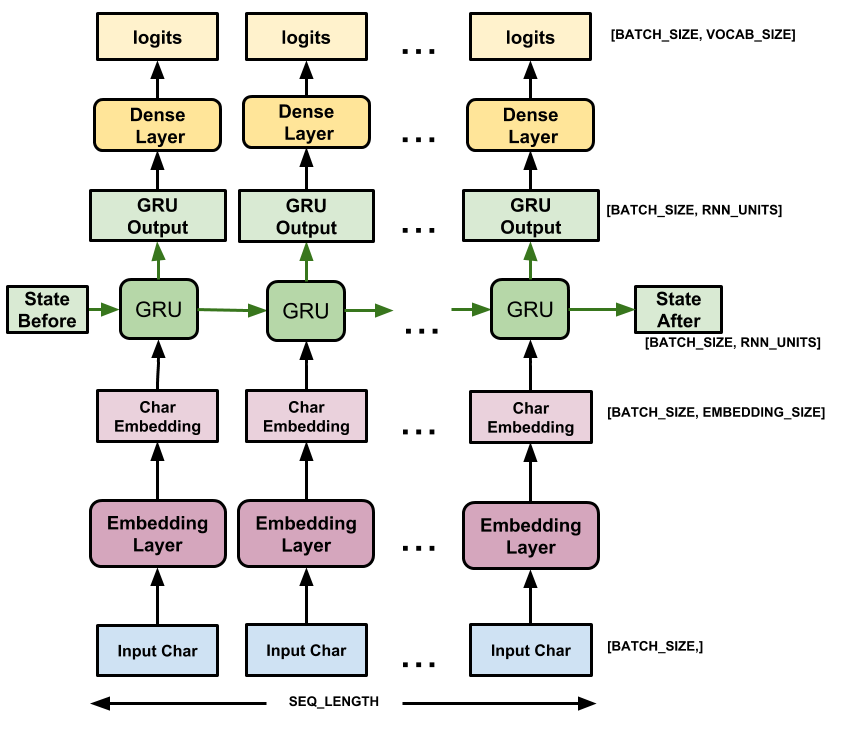

In [29]:
model = Sequential()
model.add(Embedding(total_words, 100, input_length=max_sequence_len-1))
model.add(Bidirectional(GRU(150, return_sequences = True)))
model.add(GRU(100))
model.add(Dense(total_words/2, activation='relu' ))
model.add(Dense(total_words, activation='softmax'))

In [30]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [31]:
import time
start = time.perf_counter()
history = model.fit(predictors, label, epochs=100, verbose=1)
elapsed = time.perf_counter() - start
print('============================\n Elapsed %.3f seconds.' % elapsed)

Epoch 1/100
47/47 [==============================] - 6s 39ms/step - loss: 6.2408 - accuracy: 0.0512
Epoch 2/100
47/47 [==============================] - 2s 39ms/step - loss: 5.8674 - accuracy: 0.0585
Epoch 3/100
47/47 [==============================] - 2s 39ms/step - loss: 5.6603 - accuracy: 0.0705
Epoch 4/100
47/47 [==============================] - 2s 39ms/step - loss: 5.4505 - accuracy: 0.0751
Epoch 5/100
47/47 [==============================] - 2s 39ms/step - loss: 5.2189 - accuracy: 0.0805
Epoch 6/100
47/47 [==============================] - 2s 39ms/step - loss: 4.9744 - accuracy: 0.0891
Epoch 7/100
47/47 [==============================] - 2s 39ms/step - loss: 4.7066 - accuracy: 0.0891
Epoch 8/100
47/47 [==============================] - 2s 39ms/step - loss: 4.3996 - accuracy: 0.1104
Epoch 9/100
47/47 [==============================] - 2s 39ms/step - loss: 4.0485 - accuracy: 0.1237
Epoch 10/100
47/47 [==============================] - 2s 39ms/step - loss: 3.7119 - accuracy: 0.1596

47/47 [==============================] - 2s 40ms/step - loss: 0.1933 - accuracy: 0.9182
Epoch 83/100
47/47 [==============================] - 2s 39ms/step - loss: 0.1935 - accuracy: 0.9202
Epoch 84/100
47/47 [==============================] - 2s 39ms/step - loss: 0.1911 - accuracy: 0.9162
Epoch 85/100
47/47 [==============================] - 2s 40ms/step - loss: 0.1936 - accuracy: 0.9176
Epoch 86/100
47/47 [==============================] - 2s 40ms/step - loss: 0.1964 - accuracy: 0.9149
Epoch 87/100
47/47 [==============================] - 2s 39ms/step - loss: 0.1903 - accuracy: 0.9182
Epoch 88/100
47/47 [==============================] - 2s 39ms/step - loss: 0.1884 - accuracy: 0.9189
Epoch 89/100
47/47 [==============================] - 2s 40ms/step - loss: 0.1926 - accuracy: 0.9136
Epoch 90/100
47/47 [==============================] - 2s 40ms/step - loss: 0.1885 - accuracy: 0.9202
Epoch 91/100
47/47 [==============================] - 2s 39ms/step - loss: 0.1884 - accuracy: 0.9136
Epo